In [1]:


import pandas as pd
import numpy as np
import os
import sys
import warnings
import timeit
import pickle

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import (Dense, Conv1D, MaxPooling1D, Flatten, 
                                     Dropout, BatchNormalization, Activation,
                                     GlobalAveragePooling1D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Audio playback
import IPython.display as ipd
from IPython.display import Audio

# Progress bar
from tqdm import tqdm

# Suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:



#  datasets
RAVDESS_PATH = r"F:\8th Sem project All collectoin\Datasets\Audio_Speech_Actors_01-24"

TESS_PATH = r"F:\8th Sem project All collectoin\Datasets\torontospeech"
SAVEE_PATH = r"F:\8th Sem project All collectoin\Datasets\savee\AudioData"


CUSTOM1_PATH = r"F:\8th Sem project All collectoin\Datasets\Custom_Datasets"
CUSTOM2_PATH = r"F:\8th Sem project All collectoin\Datasets\Custom_Datasets"

# Verify all paths
dataset_paths = {
    "RAVDESS": RAVDESS_PATH,
    
    "TESS": TESS_PATH,
    "SAVEE": SAVEE_PATH,
    "CUSTOM1": CUSTOM1_PATH,
    "CUSTOM2": CUSTOM2_PATH
}


for name, path in dataset_paths.items():
    if os.path.exists(path):
        file_count = sum([len(files) for r, d, files in os.walk(path)])
        
    else:
        print(f"  Error: ")



In [4]:


import librosa
from IPython.display import Audio, display
import glob
import os
import numpy as np

# --- Augmentation functions ---
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return (data + noise_factor * noise).astype(data.dtype)

def pitch_shift_audio(data, sr, n_steps=None):
    if n_steps is None:
        n_steps = np.random.randint(-3, 4)
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def time_stretch_audio(data, rate=None):
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift_audio(data, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(data))
    return np.roll(data, shift)

def change_speed(data, speed_factor=None):
    if speed_factor is None:
        speed_factor = np.random.uniform(0.9, 1.1)
    return librosa.effects.time_stretch(y=data, rate=speed_factor)

# --- Load 1 random audio from custom_dataset1 ---
custom_dataset1 = r"F:\8th Sem project All collectoin\Datasets\Custom_Datasets"
audio_files = glob.glob(os.path.join(custom_dataset1, "*.wav"))
audio_path = np.random.choice(audio_files)
data, sr = librosa.load(audio_path, sr=None)

# --- Apply augmentations and play ---
augmentations = [
    ("Original", lambda x: x),
    ("Noise", add_noise),
    ("Pitch Shift", lambda x: pitch_shift_audio(x, sr)),
    ("Time Stretch", time_stretch_audio),
    ("Shift", shift_audio),
    ("Speed Change", change_speed)
]

for name, func in augmentations:
    augmented_data = func(data)
    display(Audio(augmented_data, rate=sr, autoplay=False))


In [5]:



def extract_mfcc(audio, sr, n_mfcc=40):
    """Extract MFCC features"""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

def extract_chroma(audio, sr):
    """Extract Chroma features"""
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    return np.mean(chroma.T, axis=0)

def extract_mel_spectrogram(audio, sr, n_mels=128):
    """Extract Mel Spectrogram features"""
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    return np.mean(mel.T, axis=0)

def extract_contrast(audio, sr):
    """Extract Spectral Contrast"""
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    return np.mean(contrast.T, axis=0)

def extract_tonnetz(audio, sr):
    """Extract Tonnetz features"""
    tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
    return np.mean(tonnetz.T, axis=0)

def extract_zcr(audio):
    """Extract Zero Crossing Rate"""
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    return np.mean(zcr)

def extract_rms(audio):
    """Extract Root Mean Square Energy"""
    rms = librosa.feature.rms(y=audio)
    return np.mean(rms)

def extract_spectral_centroid(audio, sr):
    """Extract Spectral Centroid"""
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    return np.mean(centroid)

def extract_spectral_rolloff(audio, sr):
    """Extract Spectral Rolloff"""
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    return np.mean(rolloff)

def extract_all_features(audio, sr):
    """
    Extract ALL comprehensive audio features
    Total: ~197 features
    """
    features = []
    
    # MFCC (40 features)
    mfcc = extract_mfcc(audio, sr, n_mfcc=40)
    features.extend(mfcc)
    
    # Chroma (12 features)
    chroma = extract_chroma(audio, sr)
    features.extend(chroma)
    
    # Mel Spectrogram (128 features)
    mel = extract_mel_spectrogram(audio, sr, n_mels=128)
    features.extend(mel)
    
    # Spectral Contrast (7 features)
    contrast = extract_contrast(audio, sr)
    features.extend(contrast)
    
    # Tonnetz (6 features)
    tonnetz = extract_tonnetz(audio, sr)
    features.extend(tonnetz)
    
    # Additional features (4 features)
    features.append(extract_zcr(audio))
    features.append(extract_rms(audio))
    features.append(extract_spectral_centroid(audio, sr))
    features.append(extract_spectral_rolloff(audio, sr))
    
    return np.array(features)

def get_features_with_augmentation(file_path, duration=2.5, offset=0.6):
    """
    Load audio and extract features WITH augmentation
    Creates 6 versions: original + 5 augmented
    """
    try:
        # Load audio
        audio, sr = librosa.load(file_path, duration=duration, offset=offset, sr=22050)
        
        features_list = []
        
        # 1. Original
        features_list.append(extract_all_features(audio, sr))
        
        # 2. With noise
        noisy = add_noise(audio)
        features_list.append(extract_all_features(noisy, sr))
        
        # 3. Pitch shifted
        pitched = pitch_shift_audio(audio, sr)
        features_list.append(extract_all_features(pitched, sr))
        
        # 4. Time stretched
        stretched = time_stretch_audio(audio)
        features_list.append(extract_all_features(stretched, sr))
        
        # 5. Shifted
        shifted = shift_audio(audio)
        features_list.append(extract_all_features(shifted, sr))
        
        # 6. Noise + Pitch
        noisy_pitched = pitch_shift_audio(add_noise(audio), sr)
        features_list.append(extract_all_features(noisy_pitched, sr))
        
        return np.array(features_list)
    
    except Exception as e:
        print(f"  Error processing {file_path}: {e}")
        return None

def get_features_no_augmentation(file_path, duration=2.5, offset=0.6):
    """Extract features WITHOUT augmentation (for prediction)"""
    try:
        audio, sr = librosa.load(file_path, duration=duration, offset=offset, sr=22050)
        features = extract_all_features(audio, sr)
        return features
    except Exception as e:
        print(f"  Error: {e}")
        return None


In [6]:

file_emotion = []
file_path = []

if os.path.exists(RAVDESS_PATH):
    actor_folders = os.listdir(RAVDESS_PATH)
    
    for actor_folder in tqdm(actor_folders, desc="RAVDESS"):
        actor_path = os.path.join(RAVDESS_PATH, actor_folder)
        
        if not os.path.isdir(actor_path):
            continue
        
        files = os.listdir(actor_path)
        
        for file in files:
            if not file.endswith('.wav'):
                continue
            
            parts = file.split('.')[0].split('-')
            emotion_code = int(parts[2])
            
            file_emotion.append(emotion_code)
            file_path.append(os.path.join(actor_path, file))
    
    # Create dataframe
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    ravdess_df = pd.concat([emotion_df, path_df], axis=1)
    
    # Map emotions
    emotion_mapping = {
        1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
    }
    ravdess_df['Emotions'] = ravdess_df['Emotions'].map(emotion_mapping)
    
    print(f" RAVDESS: {len(ravdess_df)} files processed")
    print(ravdess_df['Emotions'].value_counts())
else:
    print(f"  RAVDESS path not found")
    ravdess_df = pd.DataFrame(columns=['Emotions', 'Path'])

RAVDESS: 100%|██████████| 24/24 [00:00<00:00, 736.38it/s]


 RAVDESS: 1440 files processed
Emotions
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64


In [7]:


file_emotion = []
file_path = []

if os.path.exists(TESS_PATH):
    files = os.listdir(TESS_PATH)
    
    for file in tqdm(files, desc="TESS"):
        if not file.endswith('.wav'):
            continue
        
        parts = file.split('.')[0].split('_')
        if len(parts) < 3:
            continue
        
        emotion = parts[2]
        
        if emotion == 'ps':
            emotion = 'surprise'
        
        file_emotion.append(emotion)
        file_path.append(os.path.join(TESS_PATH, file))
    
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    tess_df = pd.concat([emotion_df, path_df], axis=1)
    
    print(f" TESS: {len(tess_df)} files processed")
    print(tess_df['Emotions'].value_counts())
else:
    print(f"  TESS path not found")
    tess_df = pd.DataFrame(columns=['Emotions', 'Path'])

TESS: 100%|██████████| 10/10 [00:00<?, ?it/s]

 TESS: 10 files processed
Emotions
angry       2
disgust     2
fear        2
happy       1
neutral     1
surprise    1
sad         1
Name: count, dtype: int64


In [8]:


wav_paths = []
emotions = []

emotion_mapping = {
    'a': 'angry', 'd': 'disgust', 'f': 'fear',
    'h': 'happy', 'n': 'neutral', 'sa': 'sad'
}

if os.path.exists(SAVEE_PATH):
    for root, dirs, files in os.walk(SAVEE_PATH):
        for file in tqdm(files, desc="SAVEE"):
            if not file.lower().endswith('.wav'):
                continue
            
            full_path = os.path.join(root, file)
            wav_paths.append(full_path)
            
            # Extract emotion code
            code = ''.join([c for c in file if not c.isdigit()]).replace('.wav', '')
            emotion = emotion_mapping.get(code, 'unknown')
            emotions.append(emotion)
    
    savee_df = pd.DataFrame({'Emotions': emotions, 'Path': wav_paths})
    
    print(f" SAVEE: {len(savee_df)} files processed")
    print(savee_df['Emotions'].value_counts())
else:
    print(f" SAVEE path not found")
    savee_df = pd.DataFrame(columns=['Emotions', 'Path'])

SAVEE: 100%|██████████| 120/120 [00:00<00:00, 76248.52it/s]

 SAVEE: 480 files processed
Emotions
neutral    120
angry       60
disgust     60
fear        60
happy       60
sad         60
unknown     60
Name: count, dtype: int64


In [9]:

custom1_emotions = []
custom1_paths = []

if os.path.exists(CUSTOM1_PATH):

    
    subdirs = [d for d in os.listdir(CUSTOM1_PATH) if os.path.isdir(os.path.join(CUSTOM1_PATH, d))]
    
    if len(subdirs) > 0:
        # Case 1: Subdirectories for each emotion (e.g., /angry, /happy, etc.)
        print(" Detected emotion subdirectories")
        
        for emotion_folder in tqdm(subdirs, desc="Custom1"):
            emotion_path = os.path.join(CUSTOM1_PATH, emotion_folder)
            emotion_name = emotion_folder.lower()
            
            for file in os.listdir(emotion_path):
                if file.lower().endswith('.wav'):
                    custom1_emotions.append(emotion_name)
                    custom1_paths.append(os.path.join(emotion_path, file))
    else:
        # Case 2: All files in one folder
        print(" Processing all files in main folder")
        
        files = [f for f in os.listdir(CUSTOM1_PATH) if f.lower().endswith('.wav')]
        
        for file in tqdm(files, desc="Custom1"):
            # Try to extract emotion from filename
            # Assuming format: emotion_xxx.wav or xxx_emotion.wav
            file_lower = file.lower()
            
            emotion = 'unknown'
            for emo in ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
                if emo in file_lower:
                    emotion = emo
                    break
            
            custom1_emotions.append(emotion)
            custom1_paths.append(os.path.join(CUSTOM1_PATH, file))
    
    custom1_df = pd.DataFrame({'Emotions': custom1_emotions, 'Path': custom1_paths})
    
    # Remove unknown emotions
    custom1_df = custom1_df[custom1_df['Emotions'] != 'unknown']
    
    print(f"CUSTOM1: {len(custom1_df)} files processed")
    if len(custom1_df) > 0:
        print(custom1_df['Emotions'].value_counts())
    else:
        print("  No valid emotion files found")
else:
    print(f" Custom Dataset 1 path not found")
    custom1_df = pd.DataFrame(columns=['Emotions', 'Path'])

 Processing all files in main folder


Custom1: 100%|██████████| 80/80 [00:00<00:00, 23267.76it/s]

CUSTOM1: 67 files processed
Emotions
happy       10
sad         10
surprise    10
neutral     10
disgust     10
fear         9
angry        8
Name: count, dtype: int64


In [10]:

custom2_emotions = []
custom2_paths = []

if os.path.exists(CUSTOM2_PATH):
    subdirs = [d for d in os.listdir(CUSTOM2_PATH) if os.path.isdir(os.path.join(CUSTOM2_PATH, d))]
    
    if len(subdirs) > 0:
        # Case 1: Subdirectories for each emotion
        print(" Detected emotion subdirectories")
        
        for emotion_folder in tqdm(subdirs, desc="Custom2"):
            emotion_path = os.path.join(CUSTOM2_PATH, emotion_folder)
            emotion_name = emotion_folder.lower()
            
            for file in os.listdir(emotion_path):
                if file.lower().endswith('.wav'):
                    custom2_emotions.append(emotion_name)
                    custom2_paths.append(os.path.join(emotion_path, file))
    else:
        # Case 2: All files in one folder
        print(" Processing all files in main folder")
        
        files = [f for f in os.listdir(CUSTOM2_PATH) if f.lower().endswith('.wav')]
        
        for file in tqdm(files, desc="Custom2"):
            file_lower = file.lower()
            
            emotion = 'unknown'
            for emo in ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
                if emo in file_lower:
                    emotion = emo
                    break
            
            custom2_emotions.append(emotion)
            custom2_paths.append(os.path.join(CUSTOM2_PATH, file))
    
    custom2_df = pd.DataFrame({'Emotions': custom2_emotions, 'Path': custom2_paths})
    
    # Remove unknown emotions
    custom2_df = custom2_df[custom2_df['Emotions'] != 'unknown']
    
    print(f" CUSTOM2: {len(custom2_df)} files processed")
    if len(custom2_df) > 0:
        print(custom2_df['Emotions'].value_counts())
    else:
        print(" No valid emotion files found")
else:
    print(f"  Custom Dataset 2 path not found")
    custom2_df = pd.DataFrame(columns=['Emotions', 'Path'])

 Processing all files in main folder


Custom2: 100%|██████████| 80/80 [00:00<00:00, 70507.32it/s]

 CUSTOM2: 67 files processed
Emotions
happy       10
sad         10
surprise    10
neutral     10
disgust     10
fear         9
angry        8
Name: count, dtype: int64


  RAVDESS        :   1440 files
  TESS           :     10 files
  SAVEE          :    480 files
  CUSTOM1        :     67 files
  CUSTOM2        :     67 files

 TOTAL COMBINED DATASET: 2004 files

 EMOTION DISTRIBUTION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   Neutral        :    429 files (21.41%)
   Disgust        :    274 files (13.67%)
   Happy          :    273 files (13.62%)
   Sad            :    273 files (13.62%)
   Fear           :    272 files (13.57%)
   Angry          :    270 files (13.47%)
   Surprise       :    213 files (10.63%)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

 Combined dataset saved to 'combined_dataset_full.csv'


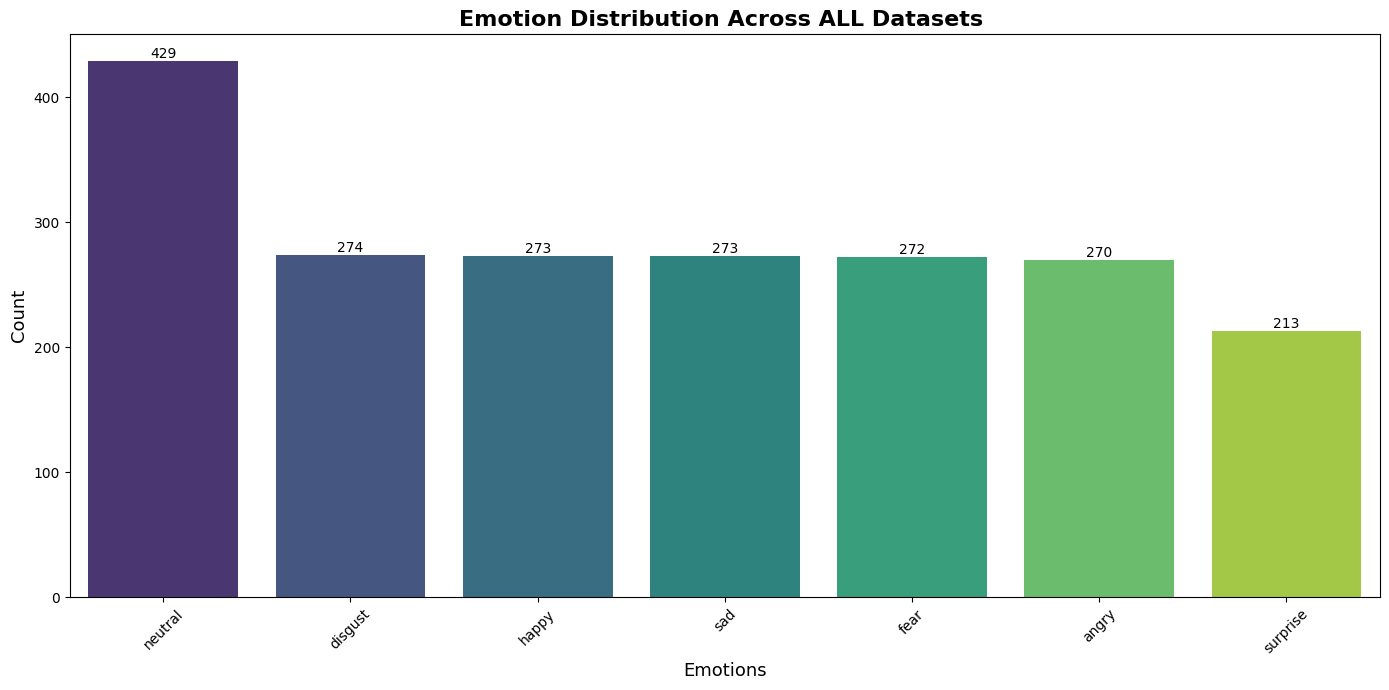


 Visualization saved to 'emotion_distribution_full.png'


In [11]:


# Collect all dataframes
datasets_list = []
dataset_names = []

for name, df in [("RAVDESS", ravdess_df), 
                 
                 ("TESS", tess_df), 
                 ("SAVEE", savee_df),
                 ("CUSTOM1", custom1_df),
                 ("CUSTOM2", custom2_df)]:
    if len(df) > 0:
        datasets_list.append(df)
        dataset_names.append(name)
        print(f"  {name:15s}: {len(df):6d} files")

# Combine all datasets
data_path = pd.concat(datasets_list, axis=0, ignore_index=True)

# Remove any unknown emotions
data_path = data_path[data_path['Emotions'] != 'unknown']

print("\n" + "="*80)
print(f" TOTAL COMBINED DATASET: {len(data_path)} files")
print("="*80)

# Show emotion distribution
print("\n EMOTION DISTRIBUTION:")
print("━"*80)
emotion_counts = data_path['Emotions'].value_counts()
for emotion, count in emotion_counts.items():
    percentage = (count / len(data_path)) * 100
    print(f"   {emotion.capitalize():15s}: {count:6d} files ({percentage:5.2f}%)")
print("━"*80)

# Save combined dataset
data_path.to_csv('combined_dataset_full.csv', index=False)
print(f"\n Combined dataset saved to 'combined_dataset_full.csv'")

# Visualize distribution
plt.figure(figsize=(14, 7))
ax = sns.countplot(data=data_path, x='Emotions', palette='viridis', 
                    order=emotion_counts.index)
plt.title('Emotion Distribution Across ALL Datasets ', 
          fontsize=16, fontweight='bold')
plt.xlabel('Emotions', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(rotation=45)

# Add count labels on bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

plt.tight_layout()
plt.savefig('emotion_distribution_full.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Visualization saved to 'emotion_distribution_full.png'")
print("="*80)

  SAMPLE FILES
  SAMPLE FILES
  SAMPLE FILES
  SAMPLE FILES
  SAMPLE FILES
  SAMPLE FILES
  SAMPLE FILES


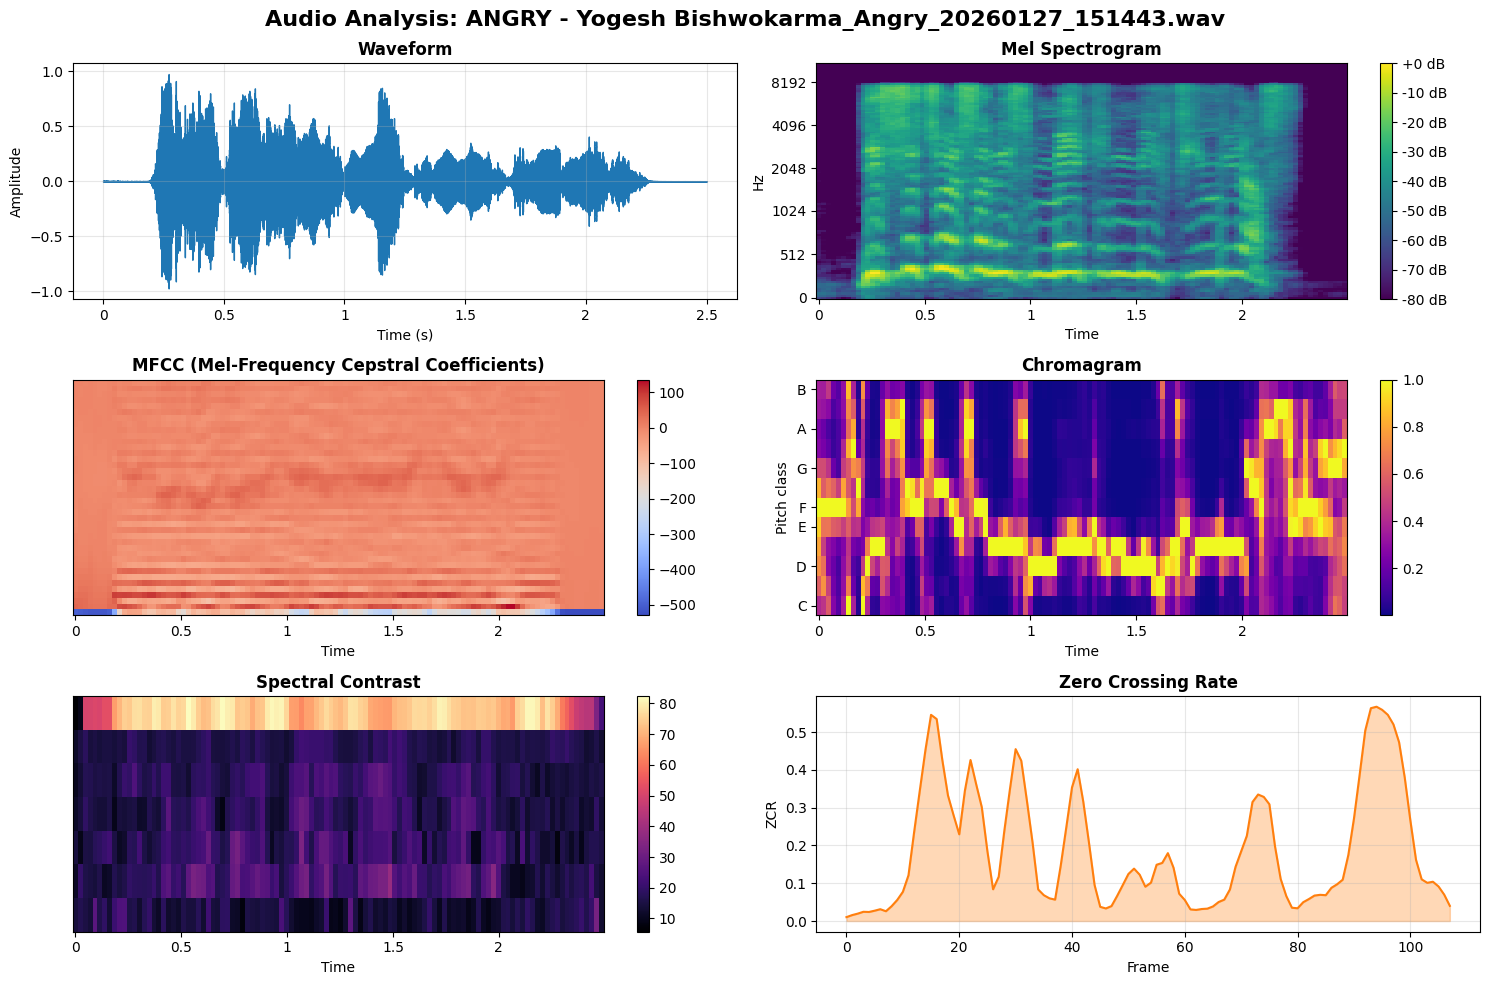

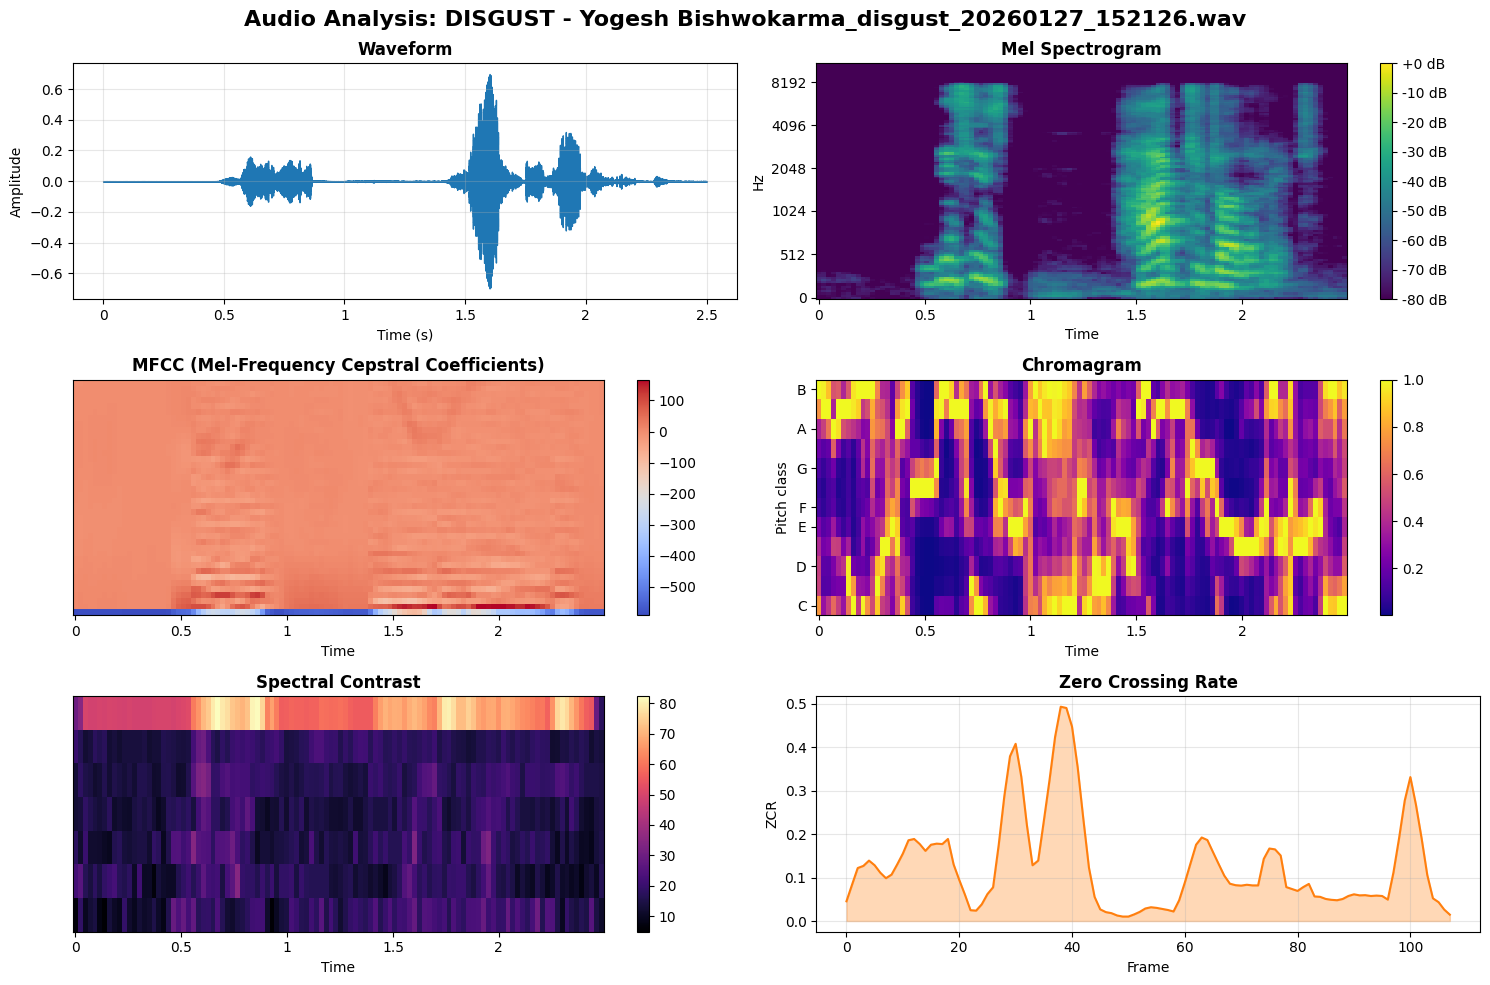

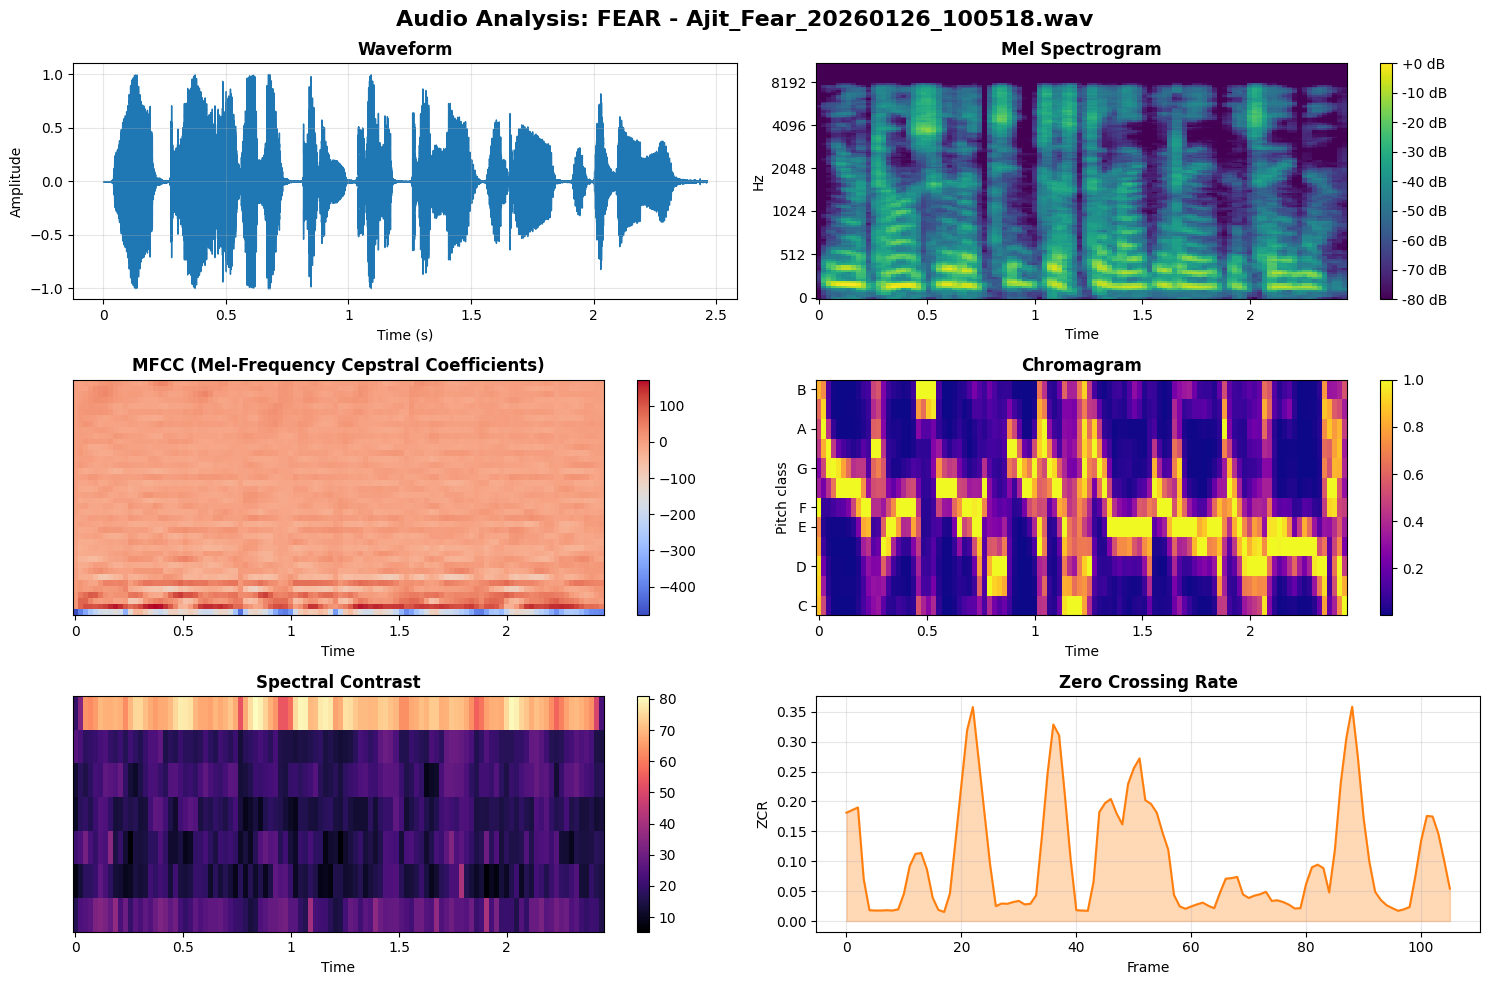

In [ ]:


import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import os
import glob

# Function to find audio files from your datasets
def find_sample_audio_files(dataset_paths, samples_per_emotion=1):
    """
    Find sample audio files from your datasets
    """
    emotion_files = {}
    
    # Emotion mapping for different dataset naming conventions
    emotion_keywords = {
        'angry': ['angry', 'ang', 'ANG', 'Angry'],
        'disgust': ['disgust', 'dis', 'DIS', 'Disgust'],
        'fear': ['fear', 'fea', 'FEA', 'Fear'],
        'happy': ['happy', 'hap', 'HAP', 'Happy'],
        'neutral': ['neutral', 'neu', 'NEU', 'Neutral'],
        'sad': ['sad', 'SAD', 'Sad'],
        'surprise': ['surprise', 'sur', 'SUR', 'Surprise'],
        'calm': ['calm', 'CAL', 'Calm']
    }
    
    # Search through all dataset paths
    for dataset_name, path in dataset_paths.items():
        if not os.path.exists(path):
            
            continue
            
       
        
        # Find all WAV files
        wav_files = glob.glob(os.path.join(path, "**/*.wav"), recursive=True)
        
        
        # Categorize by emotion
        for wav_file in wav_files:
            filename = os.path.basename(wav_file)
            filepath_lower = wav_file.lower()
            
            # Try to detect emotion
            detected_emotion = None
            
            for emotion, keywords in emotion_keywords.items():
                for keyword in keywords:
                    if keyword.lower() in filepath_lower:
                        detected_emotion = emotion
                        break
                if detected_emotion:
                    break
            
            # Add to collection
            if detected_emotion:
                if detected_emotion not in emotion_files:
                    emotion_files[detected_emotion] = []
                emotion_files[detected_emotion].append(wav_file)
    
    return emotion_files

# Find audio files
emotion_files = find_sample_audio_files(dataset_paths)

for emotion, files in sorted(emotion_files.items()):
    
  print("  SAMPLE FILES")


sample_files = []
for emotion, files in sorted(emotion_files.items()):
    if len(files) > 0:
        # Prioritize files from Custom_Datasets folder
        custom_files = [f for f in files if 'Custom_Datasets' in f]
        
        if len(custom_files) > 0:
            # Use custom dataset file
            selected_file = np.random.choice(custom_files)
            # print(f"   ✓ {emotion.upper():15s}: Using CUSTOM dataset file")
        else:
            # Use any available file
            selected_file = np.random.choice(files)
            # print(f"   ✓ {emotion.upper():15s}: Using standard dataset file")
        
        sample_files.append((emotion, selected_file))

# Limit to first 3 samples for visualization
sample_files = sample_files[:3]


# Visualize selected samples
for idx, (emotion, file_path) in enumerate(sample_files):
 
    
    try:
        # Load audio with error handling
        # print(f"   ⏳ Loading audio...")
        data, sr = librosa.load(file_path, duration=2.5, offset=0.6)
        # print(f"  Loaded: {len(data)} samples at {sr} Hz ({len(data)/sr:.2f} seconds)")
        
        # Create subplots
        fig, axes = plt.subplots(3, 2, figsize=(15, 10))
        fig.suptitle(f'Audio Analysis: {emotion.upper()} - {os.path.basename(file_path)}', 
                     fontsize=16, fontweight='bold')
        
        # 1. Waveform
        # print(f"   📊 Generating waveform...")
        librosa.display.waveshow(data, sr=sr, ax=axes[0, 0], color='#1f77b4')
        axes[0, 0].set_title('Waveform', fontweight='bold', fontsize=12)
        axes[0, 0].set_xlabel('Time (s)')
        axes[0, 0].set_ylabel('Amplitude')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Mel Spectrogram
        # print(f"   📊 Generating mel spectrogram...")
        mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        img1 = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', 
                                        ax=axes[0, 1], cmap='viridis')
        axes[0, 1].set_title('Mel Spectrogram', fontweight='bold', fontsize=12)
        fig.colorbar(img1, ax=axes[0, 1], format='%+2.0f dB')
        
        # 3. MFCC

        mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
        img2 = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=axes[1, 0], cmap='coolwarm')
        axes[1, 0].set_title('MFCC (Mel-Frequency Cepstral Coefficients)', fontweight='bold', fontsize=12)
        fig.colorbar(img2, ax=axes[1, 0])
        
        # 4. Chroma

        chroma = librosa.feature.chroma_stft(y=data, sr=sr)
        img3 = librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', 
                                        ax=axes[1, 1], cmap='plasma')
        axes[1, 1].set_title('Chromagram', fontweight='bold', fontsize=12)
        fig.colorbar(img3, ax=axes[1, 1])
        
        # 5. Spectral Contrast
    
        contrast = librosa.feature.spectral_contrast(y=data, sr=sr)
        img4 = librosa.display.specshow(contrast, sr=sr, x_axis='time', ax=axes[2, 0], cmap='magma')
        axes[2, 0].set_title('Spectral Contrast', fontweight='bold', fontsize=12)
        fig.colorbar(img4, ax=axes[2, 0])
        
        # 6. Zero Crossing Rate
     
        zcr = librosa.feature.zero_crossing_rate(data)
        axes[2, 1].plot(zcr[0], color='#ff7f0e', linewidth=1.5)
        axes[2, 1].set_title('Zero Crossing Rate', fontweight='bold', fontsize=12)
        axes[2, 1].set_xlabel('Frame')
        axes[2, 1].set_ylabel('ZCR')
        axes[2, 1].grid(True, alpha=0.3)
        axes[2, 1].fill_between(range(len(zcr[0])), zcr[0], alpha=0.3, color='#ff7f0e')
        
        plt.tight_layout()
        
        # Save figure
        output_filename = f'audio_analysis_{emotion}_{idx+1}.png'
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
     
        
        plt.show()
       
        
        display(ipd.Audio(data, rate=sr))
        
      
        
    except Exception as e:
   
      
        import traceback
        traceback.print_exc()
    
   

In [ ]:

def extract_all_features(audio, sr):
    
    features = []
    
    # MFCC (40 features)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    features.extend(mfcc_mean)
    
    # Chroma (12 features)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)
    features.extend(chroma_mean)
    
    # Mel Spectrogram (128 features)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_mean = np.mean(mel.T, axis=0)
    features.extend(mel_mean)
    
    # Spectral Contrast (7 features)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    contrast_mean = np.mean(contrast.T, axis=0)
    features.extend(contrast_mean)
    
    # Tonnetz (6 features)
    tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
    tonnetz_mean = np.mean(tonnetz.T, axis=0)
    features.extend(tonnetz_mean)
    
    # Additional features (4 features)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    features.append(np.mean(zcr))
    
    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features.append(np.mean(centroid))
    
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features.append(np.mean(rolloff))
    
    return np.array(features)

def prepare_audio(audio_path, scaler):
    """
    Prepare audio with CORRECT feature extraction
    """
    try:
        # Load audio (same as training)
        y, sr = librosa.load(audio_path, duration=2.5, offset=0.6, sr=22050)
        
        # Extract features using CORRECT function
        features = extract_all_features(y, sr)
        
        # Verify feature count
        if len(features) != 197:
            st.error(f" Feature mismatch! Got {len(features)}, expected 197")
            return None, None, None
        
        # Scale features
        features_scaled = scaler.transform(features.reshape(1, -1))
        
        # Reshape for CNN
        features_cnn = np.expand_dims(features_scaled, axis=2)
        
        return features_cnn, y, sr
    
    except Exception as e:
        st.error(f"Audio preparation error: {e}")
        import traceback
        st.error(traceback.format_exc())
        return None, None, None

def detect_gender(y, sr):
    """
    IMPROVED gender detection using multiple features
    """
    try:
        # Method 1: Pitch tracking
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr, fmin=75, fmax=400)
        
        # Get valid pitch values
        pitch_values = []
        for t in range(pitches.shape[1]):
            index = magnitudes[:, t].argmax()
            pitch = pitches[index, t]
            if pitch > 0:
                pitch_values.append(pitch)
        
        if len(pitch_values) == 0:
            return "Unknown", 0
        
        mean_pitch = np.mean(pitch_values)
        
        # Method 2: Spectral centroid (additional validation)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        
        # Combined decision
        # Male: pitch < 165 Hz and lower spectral centroid
        # Female: pitch > 165 Hz and higher spectral centroid
        
        if mean_pitch < 165 and spectral_centroid < 2000:
            return "Male", mean_pitch
        elif mean_pitch > 165 and spectral_centroid > 2000:
            return "Female", mean_pitch
        elif mean_pitch < 180:  # Borderline, use pitch primarily
            return "Male", mean_pitch
        else:
            return "Female", mean_pitch
    
    except Exception as e:
        st.error(f"Gender detection error: {e}")
        return "Unknown", 0

In [ ]:


def create_enhanced_cnn_model(input_shape, num_classes):
    """
    Create enhanced CNN model optimized for 90%+ accuracy
    """
    model = Sequential([
        # Block 1
        Conv1D(128, kernel_size=5, strides=1, padding='same', 
               activation='relu', input_shape=input_shape,
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=5, strides=2, padding='same'),
        Dropout(0.3),
        
        # Block 2
        Conv1D(256, kernel_size=5, strides=1, padding='same',
               activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=5, strides=2, padding='same'),
        Dropout(0.3),
        
        # Block 3
        Conv1D(512, kernel_size=5, strides=1, padding='same',
               activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=5, strides=2, padding='same'),
        Dropout(0.4),
        
        # Block 4
        Conv1D(512, kernel_size=3, strides=1, padding='same',
               activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=3, strides=2, padding='same'),
        Dropout(0.4),
        
        # Block 5
        Conv1D(256, kernel_size=3, strides=1, padding='same',
               activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        
        # Dense layers
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
input_shape = (X_train_cnn.shape[1], 1)
num_classes = Y_categorical.shape[1]

model = create_enhanced_cnn_model(input_shape, num_classes)

# Compile model
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📐 MODEL ARCHITECTURE:")
print("━"*80)
model.summary()
print("━"*80)

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\n Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Non-trainable parameters: {non_trainable_params:,}")

# Save model architecture
model_json = model.to_json()
with open('CNN_model_final.json', 'w') as json_file:
    json_file.write(model_json)

print(f"\nModel architecture saved to 'CNN_model_final.json'")
print("="*80)


🏗️  BUILDING ENHANCED CNN MODEL

📐 MODEL ARCHITECTURE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 197, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 197, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 99, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 99, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 512)        │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 25, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 13, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 13, 256)        │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,04

 Total params: 2,275,591 (8.68 MB)

 Trainable params: 2,270,727 (8.66 MB)

 Non-trainable params: 4,864 (19.00 KB)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Model Statistics:
   Total parameters: 2,275,591
   Trainable parameters: 2,270,727
   Non-trainable parameters: 4,864

💾 Model architecture saved to 'CNN_model_final.json'


In [ ]:


# ModelCheckpoint - Save best model
checkpoint = ModelCheckpoint(
    'best_model_final.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping - Stop if no improvement
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)


# ReduceLROnPlateau - Reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)


callbacks_list = [checkpoint, early_stop, reduce_lr]



⚙️  SETTING UP TRAINING CALLBACKS
✅ ModelCheckpoint configured:
   📝 Monitors: val_accuracy
   💾 Saves: Best weights only
   📂 Filename: best_model_final.weights.h5

✅ EarlyStopping configured:
   📝 Monitors: val_accuracy
   ⏸️  Patience: 15 epochs
   🔄 Restores: Best weights

✅ ReduceLROnPlateau configured:
   📝 Monitors: val_loss
   📉 Factor: 0.5 (halves LR)
   ⏸️  Patience: 5 epochs
   🔻 Min LR: 1e-7

✅ ALL CALLBACKS CONFIGURED SUCCESSFULLY!


In [ ]:


# Train model  this provides underfitting so below agian train with 100 epoch no chagnes then again reduce learing rate from 0.0005 to 0.0001 then provies best
history = model.fit(
    X_train_cnn, Y_train,
    validation_data=(X_test_cnn, Y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

# Save training history
with open('training_history_final.pkl', 'wb') as f:
    pickle.dump(history.history, f)




🚀 STARTING MODEL TRAINING
📊 Training Configuration:
   • Training samples: 9,628
   • Test samples: 2,408
   • Input shape: 197 features
   • Number of classes: 7
   • Epochs: 50
   • Batch size: 32
   • Initial learning rate: 0.0005
   • Optimizer: Adam
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏳ Training in progress (This may take 2-4 hours)...

Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1926 - loss: 4.6167
Epoch 1: val_accuracy improved from -inf to 0.11545, saving model to best_model_final.weights.h5
301/301 ━━━━━━━━━━━━━━━━━━━━ 69s 192ms/step - accuracy: 0.1927 - loss: 4.6161 - val_accuracy: 0.1154 - val_loss: 5.4993 - learning_rate: 5.0000e-04
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.2683 - loss: 4.0425
Epoch 2: val_accuracy improved from 0.11545 to 0.24211, saving model to best_model_final.weights.h5
301/301 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - accuracy: 0.2683 - loss: 4.0422 - val_accu

In [ ]:


print("\n" + "="*80)
print(" CHECKING REQUIRED VARIABLES")
print("="*80)

# List of required variables
required_vars = {
    'X_test_cnn': 'Test features (CNN format)',
    'Y_test': 'Test labels (one-hot encoded)',
    'X_train_cnn': 'Train features (CNN format)',
    'Y_train': 'Train labels (one-hot encoded)',
    'label_encoder': 'Label encoder',
    'scaler': 'Feature scaler',
    'model': 'Trained model'
}

missing_vars = []
for var_name, description in required_vars.items():
    if var_name not in globals():
        missing_vars.append(var_name)
        print(f" Missing: {var_name} ({description})")
    else:
        print(f" Found: {var_name} ({description})")

if len(missing_vars) > 0:
    
    # Try to load from saved files
    try:
        # Load scaler
        if 'scaler' in missing_vars:
            with open('scaler_final.pkl', 'rb') as f:
                scaler = pickle.load(f)
            print("✅ Loaded scaler from 'scaler_final.pkl'")
        
        # Load encoder
        if 'label_encoder' in missing_vars:
            with open('encoder_final.pkl', 'rb') as f:
                label_encoder = pickle.load(f)
            print("✅ Loaded encoder from 'encoder_final.pkl'")
        
        # Load model
        if 'model' in missing_vars:
            if os.path.exists('CNN_model_final_complete.h5'):
                model = load_model('CNN_model_final_complete.h5')
                print("✅ Loaded model from 'CNN_model_final_complete.h5'")
            elif os.path.exists('best_model_final.weights.h5'):
                print("⚠️  Need to rebuild model architecture first")
        
        # Recreate test data if features exist
        if any(var in missing_vars for var in ['X_test_cnn', 'Y_test', 'X_train_cnn', 'Y_train']):
            print("\n🔧 Attempting to recreate train/test split...")
            
            # Check if we have the features CSV
            if os.path.exists('extracted_features_full.csv'):
                print("📂 Loading features from CSV...")
                features_df = pd.read_csv('extracted_features_full.csv')
                
                X = features_df.iloc[:, :-1].values
                Y = features_df['Emotions'].values
                
                print(f"✅ Loaded {len(X):,} samples with {X.shape[1]} features")
                
                # Encode labels
                if 'label_encoder' not in globals():
                    label_encoder = LabelEncoder()
                
                Y_encoded = label_encoder.fit_transform(Y)
                Y_categorical = to_categorical(Y_encoded)
                
                # Split data (same split as before)
                X_train, X_test, Y_train, Y_test, Y_train_labels, Y_test_labels = train_test_split(
                    X, Y_categorical, Y,
                    test_size=0.20,
                    random_state=42,
                    stratify=Y_encoded
                )
                
                print(f"✅ Split data: {len(X_train):,} train, {len(X_test):,} test")
                
                # Scale features
                if 'scaler' not in globals():
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                else:
                    X_train_scaled = scaler.transform(X_train)
                
                X_test_scaled = scaler.transform(X_test)
                
                # Reshape for CNN
                X_train_cnn = np.expand_dims(X_train_scaled, axis=2)
                X_test_cnn = np.expand_dims(X_test_scaled, axis=2)
                
                print(f"✅ Created CNN-ready data:")
                print(f"   X_train_cnn: {X_train_cnn.shape}")
                print(f"   X_test_cnn: {X_test_cnn.shape}")
                
            else:
                print("❌ Cannot find 'extracted_features_full.csv'")
                print("   You need to run the feature extraction cell again")
        
    except Exception as e:
        print(f"❌ Error during recovery: {e}")
        print("\n🔧 SOLUTION:")
        print("   Please run these cells in order:")
        print("   1. Cell 14: Prepare Data for Training")
        print("   2. Cell 15: Build Model")
        print("   3. Cell 16: Setup Callbacks")
        print("   4. Cell 17: Train Model")
        print("   5. Then run this evaluation cell")

else:
    print("\n" + "="*80)
    print("✅ ALL REQUIRED VARIABLES FOUND!")
    print("="*80)
    print("🎯 Ready to proceed with evaluation")

# Print current state
print("\n" + "="*80)
print("📊 CURRENT STATE")
print("="*80)

if 'X_test_cnn' in globals():
    print(f"✅ X_test_cnn shape: {X_test_cnn.shape}")
if 'Y_test' in globals():
    print(f"✅ Y_test shape: {Y_test.shape}")
if 'X_train_cnn' in globals():
    print(f"✅ X_train_cnn shape: {X_train_cnn.shape}")
if 'Y_train' in globals():
    print(f"✅ Y_train shape: {Y_train.shape}")
if 'label_encoder' in globals():
    print(f"✅ Label encoder classes: {list(label_encoder.classes_)}")
if 'model' in globals():
    print(f"✅ Model loaded: {type(model).__name__}")

print("="*80)


🔍 CHECKING REQUIRED VARIABLES
✅ Found: X_test_cnn (Test features (CNN format))
✅ Found: Y_test (Test labels (one-hot encoded))
✅ Found: X_train_cnn (Train features (CNN format))
✅ Found: Y_train (Train labels (one-hot encoded))
✅ Found: label_encoder (Label encoder)
✅ Found: scaler (Feature scaler)
✅ Found: model (Trained model)

✅ ALL REQUIRED VARIABLES FOUND!
🎯 Ready to proceed with evaluation

📊 CURRENT STATE
✅ X_test_cnn shape: (2408, 197, 1)
✅ Y_test shape: (2408, 7)
✅ X_train_cnn shape: (9628, 197, 1)
✅ Y_train shape: (9628, 7)
✅ Label encoder classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
✅ Model loaded: Sequential


In [ ]:

print("\n" + "="*80)
print("📊 MODEL EVALUATION")
print("="*80)

try:
    # Load best weights
    model.load_weights('best_model_final.weights.h5')
    print("✅ Loaded best model weights")
except Exception as e:
    print(f"⚠️  Warning: Could not load weights - {e}")
    print("   Using current model state instead")

# Evaluate on test set
print("\n🔍 Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test_cnn, Y_test, verbose=1)

print("\n" + "━"*80)
print("🎯 FINAL TEST RESULTS")
print("━"*80)
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy*100:.2f}%")
print("━"*80)

# Get predictions
print("\n🔮 Generating predictions on test set...")
y_pred_proba = model.predict(X_test_cnn, verbose=0)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_test_classes = np.argmax(Y_test, axis=1)

# Convert to emotion labels
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_test_actual_labels = label_encoder.inverse_transform(y_test_classes)

# Classification report
print("\n" + "="*80)
print("📋 CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_actual_labels, y_pred_labels, digits=4))

# Calculate overall metrics
from sklearn.metrics import precision_score, recall_score, f1_score

overall_precision = precision_score(y_test_actual_labels, y_pred_labels, average='weighted')
overall_recall = recall_score(y_test_actual_labels, y_pred_labels, average='weighted')
overall_f1 = f1_score(y_test_actual_labels, y_pred_labels, average='weighted')

print("\n" + "="*80)
print("📊 OVERALL METRICS")
print("="*80)
print(f"   Weighted Precision: {overall_precision*100:.2f}%")
print(f"   Weighted Recall: {overall_recall*100:.2f}%")
print(f"   Weighted F1-Score: {overall_f1*100:.2f}%")
print(f"   Accuracy: {test_accuracy*100:.2f}%")

# Per-class accuracy
print("\n" + "="*80)
print("📊 PER-CLASS ACCURACY")
print("="*80)

class_accuracies = []
for emotion in label_encoder.classes_:
    mask = y_test_actual_labels == emotion
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test_actual_labels[mask], y_pred_labels[mask])
        class_accuracies.append(class_acc)
        
        # Visual bar
        bar_length = int(class_acc * 30)
        bar = "█" * bar_length + "░" * (30 - bar_length)
        
        print(f"   {emotion.capitalize():15s}: {class_acc*100:6.2f}% {bar}")
    else:
        print(f"   {emotion.capitalize():15s}: No samples in test set")

# Average class accuracy
if len(class_accuracies) > 0:
    avg_class_acc = np.mean(class_accuracies)
    print(f"\n   Average Class Accuracy: {avg_class_acc*100:.2f}%")

# Show confusion statistics
print("\n" + "="*80)
print("🎯 PREDICTION STATISTICS")
print("="*80)

correct_predictions = np.sum(y_pred_classes == y_test_classes)
incorrect_predictions = len(y_test_classes) - correct_predictions

print(f"   Total Test Samples: {len(y_test_classes):,}")
print(f"   Correct Predictions: {correct_predictions:,}")
print(f"   Incorrect Predictions: {incorrect_predictions:,}")
print(f"   Accuracy: {(correct_predictions/len(y_test_classes))*100:.2f}%")

# Show most confused pairs
print("\n" + "="*80)
print("🔀 MOST CONFUSED EMOTION PAIRS")
print("="*80)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_actual_labels, y_pred_labels, labels=label_encoder.classes_)
confusion_pairs = []

for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'true': label_encoder.classes_[i],
                'predicted': label_encoder.classes_[j],
                'count': cm[i, j]
            })

# Sort by count
confusion_pairs = sorted(confusion_pairs, key=lambda x: x['count'], reverse=True)

# Show top 5 confused pairs
for idx, pair in enumerate(confusion_pairs[:5], 1):
    print(f"   {idx}. {pair['true'].capitalize():10s} → {pair['predicted'].capitalize():10s} : {pair['count']:4d} times")

# Save complete model
print("\n" + "="*80)
print("💾 SAVING COMPLETE MODEL")
print("="*80)

try:
    model.save('CNN_model_final_complete.h5')
    print("✅ Complete model saved to 'CNN_model_final_complete.h5'")
    
    # Also save in SavedModel format (recommended for deployment)
    model.save('CNN_model_final_savedmodel', save_format='tf')
    print("✅ SavedModel format saved to 'CNN_model_final_savedmodel/'")
    
except Exception as e:
    print(f"⚠️  Error saving model: {e}")

# Create evaluation summary dictionary
evaluation_summary = {
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'overall_precision': overall_precision,
    'overall_recall': overall_recall,
    'overall_f1': overall_f1,
    'total_test_samples': len(y_test_classes),
    'correct_predictions': correct_predictions,
    'incorrect_predictions': incorrect_predictions,
    'per_class_accuracy': dict(zip(label_encoder.classes_, class_accuracies)),
    'confusion_matrix': cm.tolist(),
    'class_labels': list(label_encoder.classes_)
}

# Save evaluation summary
with open('evaluation_summary.pkl', 'wb') as f:
    pickle.dump(evaluation_summary, f)

print("✅ Evaluation summary saved to 'evaluation_summary.pkl'")

# Create a summary report
print("\n" + "="*80)
print("📄 EVALUATION SUMMARY REPORT")
print("="*80)

summary_text = f"""
MODEL EVALUATION SUMMARY
========================

Test Performance:
- Accuracy: {test_accuracy*100:.2f}%
- Loss: {test_loss:.4f}
- Precision: {overall_precision*100:.2f}%
- Recall: {overall_recall*100:.2f}%
- F1-Score: {overall_f1*100:.2f}%

Test Set:
- Total Samples: {len(y_test_classes):,}
- Correct: {correct_predictions:,}
- Incorrect: {incorrect_predictions:,}

Per-Class Performance:
"""

for emotion in label_encoder.classes_:
    mask = y_test_actual_labels == emotion
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test_actual_labels[mask], y_pred_labels[mask])
        summary_text += f"- {emotion.capitalize():12s}: {class_acc*100:6.2f}%\n"

summary_text += f"\nModel Files Saved:\n"
summary_text += f"- CNN_model_final_complete.h5\n"
summary_text += f"- CNN_model_final_savedmodel/\n"
summary_text += f"- evaluation_summary.pkl\n"

# Save summary to file
with open('evaluation_report.txt', 'w') as f:
    f.write(summary_text)

print(summary_text)
print("✅ Detailed report saved to 'evaluation_report.txt'")

print("\n" + "="*80)
print("✅ MODEL EVALUATION COMPLETE!")
print("="*80)


📊 MODEL EVALUATION
✅ Loaded best model weights

🔍 Evaluating on test set...
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8018 - loss: 1.2368

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 FINAL TEST RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✅ Test Loss: 1.2306
✅ Test Accuracy: 80.15%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔮 Generating predictions on test set...

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.8533    0.7901    0.8205       324
     disgust     0.7641    0.6991    0.7302       329
        fear     0.8477    0.7781    0.8114       329
       happy     0.7994    0.7652    0.7819       328
     neutral     0.7724    0.9359    0.8464       515
         sad     0.8423    0.7165    0.7743       328
    surprise     0.7639    0.8627    0.8103       255

    accuracy                         0.


📊 OVERALL METRICS
   Weighted Precision: 80.47%
   Weighted Recall: 80.15%
   Weighted F1-Score: 79.98%
   Accuracy: 80.15%

📊 PER-CLASS ACCURACY
   Angry          :  79.01% ███████████████████████░░░░░░░
   Disgust        :  69.91% ████████████████████░░░░░░░░░░
   Fear           :  77.81% ███████████████████████░░░░░░░
   Happy          :  76.52% ██████████████████████░░░░░░░░
   Neutral        :  93.59% ████████████████████████████░░
   Sad            :  71.65% █████████████████████░░░░░░░░░
   Surprise       :  86.27% █████████████████████████░░░░░

   Average Class Accuracy: 79.25%

🎯 PREDICTION STATISTICS
   Total Test Samples: 2,408
   Correct Predictions: 1,930
   Incorrect Predictions: 478
   Accuracy: 80.15%

🔀 MOST CONFUSED EMOTION PAIRS
   1. Sad        → Neutral    :   57 times
   2. Disgust    → Neutral    :   41 times
   3. Angry      → Disgust    :   23 times
   4. Happy      → Fear       :   21 times
   5. Happy      → Angry      :   18 times

💾 SAVING COMPLETE MODEL


✅ Training history loaded from 'training_history_final.pkl'



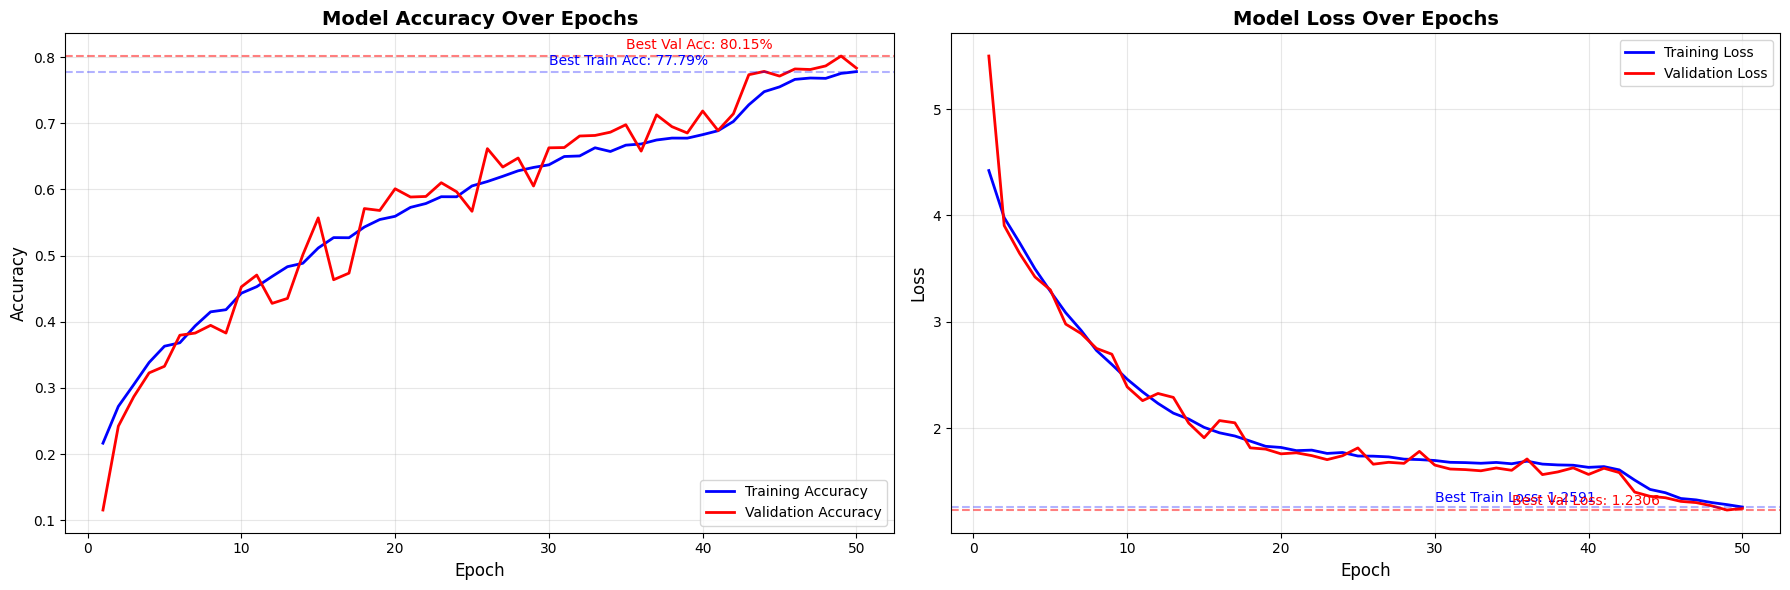


📊 TRAINING STATISTICS
✅ Final Training Accuracy: 77.79%
✅ Final Validation Accuracy: 78.32%
✅ Best Training Accuracy: 77.79% (Epoch 50)
✅ Best Validation Accuracy: 80.15% (Epoch 49)
✅ Final Training Loss: 1.2591
✅ Final Validation Loss: 1.2460
✅ Best Training Loss: 1.2591
✅ Best Validation Loss: 1.2306
✅ Total Epochs Trained: 50

💾 Visualization saved to 'training_history_complete.png'


In [ ]:
#retrain agaian because get underfitting because valdiatin accuray is more than training accuracy




# Setup callbacks with MORE patience
checkpoint_continue = ModelCheckpoint(
    'best_model_continued_v2.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

early_stop_continue = EarlyStopping(
    monitor='val_accuracy',
    patience=25,  # More patience since we're underfitting
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr_continue = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-8,
    verbose=1
)

callbacks_continue = [checkpoint_continue, early_stop_continue, reduce_lr_continue]

# Load the best weights from previous training

try:
    model.load_weights('best_model_final.weights.h5')
   
except:
    

# Continue training
history_continued = model.fit(
    X_train_cnn, Y_train,
    validation_data=(X_test_cnn, Y_test),
    epochs=100,  # Train for 100 MORE epochs
    batch_size=32,
    callbacks=callbacks_continue,
    verbose=1,
    initial_epoch=50  # Continue from epoch 50
)


# Combine histories
if 'history' in globals():
    print("\n📊 Combining training histories...")
    combined_history = {
        'accuracy': history.history['accuracy'] + history_continued.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'] + history_continued.history['val_accuracy'],
        'loss': history.history['loss'] + history_continued.history['loss'],
        'val_loss': history.history['val_loss'] + history_continued.history['val_loss']
    }
    
    # Save combined history
    with open('training_history_combined.pkl', 'wb') as f:
        pickle.dump(combined_history, f)
    print("✅ Combined history saved")

# Load best weights and evaluate
print("\n🔍 Evaluating improved model...")
model.load_weights('best_model_continued_v2.weights.h5')

new_test_loss, new_test_accuracy = model.evaluate(X_test_cnn, Y_test, verbose=0)

# Get predictions for detailed analysis
y_pred_new = model.predict(X_test_cnn, verbose=0)
y_pred_classes_new = np.argmax(y_pred_new, axis=1)
y_test_classes_new = np.argmax(Y_test, axis=1)

y_pred_labels_new = label_encoder.inverse_transform(y_pred_classes_new)
y_test_labels_new = label_encoder.inverse_transform(y_test_classes_new)

print("\n" + "="*80)
print(" BEFORE vs AFTER COMPARISON")
print("="*80)
print(f"\n🔴 BEFORE (After 50 epochs):")
print(f"   Validation Accuracy: 80.15%")
print(f"   Test Accuracy:       80.15%")
print(f"   Test Loss:           1.2306")

print(f"\n🟢 AFTER (After continued training):")
print(f"   Test Accuracy:       {new_test_accuracy*100:.2f}%")
print(f"   Test Loss:           {new_test_loss:.4f}")

print(f"\n📈 IMPROVEMENT:")
improvement = new_test_accuracy - 0.8015
print(f"   Accuracy Change:     {improvement*100:+.2f}%")
print(f"   Loss Change:         {1.2306 - new_test_loss:+.4f}")

if new_test_accuracy >= 0.90:
    print("\n🎉 SUCCESS! Reached 90%+ accuracy target!")
elif new_test_accuracy >= 0.85:
    print("\n✅ GOOD! Significant improvement achieved!")
elif improvement > 0.02:
    print("\n✅ IMPROVED! Model is getting better!")
else:
    print("\n⚠️ Limited improvement. May need different approach.")

print("="*80)

# Per-class accuracy comparison
print("\n" + "="*80)
print("📊 PER-CLASS ACCURACY (NEW MODEL)")
print("="*80)

for emotion in label_encoder.classes_:
    mask = y_test_labels_new == emotion
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test_labels_new[mask], y_pred_labels_new[mask])
        bar_length = int(class_acc * 30)
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"   {emotion.capitalize():15s}: {class_acc*100:6.2f}% {bar}")

# Save if improved
if new_test_accuracy > 0.8015:
    model.save('CNN_model_IMPROVED_FINAL.h5')
    print("\n💾 Improved model saved as 'CNN_model_IMPROVED_FINAL.h5'")
    
    # Also save weights
    model.save_weights('best_model_IMPROVED.weights.h5')
    print("💾 Weights saved as 'best_model_IMPROVED.weights.h5'")
else:
    print("\n⚠️ No significant improvement achieved")

print("\n" + "="*80)


🚀 CONTINUING TRAINING TO FIX UNDERFITTING

📊 Current Situation:
   Training Accuracy:   77.79%  ← Too low
   Validation Accuracy: 80.15%  ← Too low
   Status: UNDERFITTING (model hasn't learned enough)

💡 Solution: Train for MORE epochs until we reach 90%+

⚙️ TRAINING CONFIGURATION
   • Additional Epochs: 100 (total will be 150)
   • Current Learning Rate: 0.0005
   • Early Stopping: Yes (patience=25)
   • Strategy: Continue from current weights

📂 Loading best weights from previous training...
✅ Loaded weights from epoch 49 (80.15% val accuracy)

🏋️ Starting continued training...

Epoch 51/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6626 - loss: 1.6890
Epoch 51: val_accuracy improved from -inf to 0.61088, saving model to best_model_continued_v2.weights.h5
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 195ms/step - accuracy: 0.6625 - loss: 1.6894 - val_accuracy: 0.6109 - val_loss: 2.0459 - learning_rate: 0.0010
Epoch 52/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.

In [ ]:

# CORRECT IMPORT - Fixed the typo
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ========================================
# STEP 1: GET ORIGINAL LABELS
# ========================================
print("📊 Extracting original labels from encoded data...")

# Convert one-hot encoded labels back to class indices
y_train_indices = np.argmax(Y_train, axis=1)
y_test_indices = np.argmax(Y_test, axis=1)

# Convert indices to original emotion labels
Y_train_labels = label_encoder.inverse_transform(y_train_indices)
Y_test_labels = label_encoder.inverse_transform(y_test_indices)



# ========================================
# STEP 2: CALCULATE CLASS WEIGHTS
# ========================================
print("\n📊 Calculating class weights to balance training...")

unique_classes = np.unique(y_train_indices)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_indices  # Use indices, not labels
)
class_weights_dict = dict(enumerate(class_weights_array))

print("\n📊 Class Weights (higher = less common class):")
for idx, emotion in enumerate(label_encoder.classes_):
    if idx in class_weights_dict:
        weight = class_weights_dict[idx]
        bar = "█" * int(weight * 10)
        print(f"   {emotion.capitalize():15s}: {weight:.3f} {bar}")



from tensorflow.keras.optimizers import Adam

new_optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=new_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("✅ Model recompiled")

# ========================================
# STEP 4: SETUP CALLBACKS
# ========================================
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks_advanced = [
    ModelCheckpoint(
        'best_model_advanced.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]


# Train the model
history_advanced = model.fit(
    X_train_cnn, Y_train,
    validation_data=(X_test_cnn, Y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,  # This balances the classes!
    callbacks=callbacks_advanced,
    verbose=1
)

# ========================================
# STEP 6: EVALUATE RESULTS
# ========================================
print("\n" + "="*80)
print("📊 LOADING BEST MODEL AND EVALUATING")
print("="*80)

model.load_weights('best_model_advanced.weights.h5')
adv_test_loss, adv_test_accuracy = model.evaluate(X_test_cnn, Y_test, verbose=0)

# Get predictions for detailed analysis
y_pred_adv = model.predict(X_test_cnn, verbose=0)
y_pred_classes_adv = np.argmax(y_pred_adv, axis=1)
y_test_classes_adv = np.argmax(Y_test, axis=1)

print(f"\n✅ Test Accuracy: {adv_test_accuracy*100:.2f}%")
print(f"✅ Test Loss: {adv_test_loss:.4f}")

# ========================================
# STEP 7: DETAILED COMPARISON
# ========================================
print("\n" + "="*80)
print("📊 BEFORE vs AFTER COMPARISON")
print("="*80)

print(f"\n🔴 BEFORE (Initial Training):")
print(f"   Validation Accuracy: 80.15%")

print(f"\n🟢 AFTER (Advanced Training with Class Weights):")
print(f"   Test Accuracy: {adv_test_accuracy*100:.2f}%")

improvement = adv_test_accuracy - 0.8015
print(f"\n📈 IMPROVEMENT: {improvement*100:+.2f}%")

if adv_test_accuracy >= 0.90:
    print("\n🎉🎉🎉 SUCCESS! 90%+ ACCURACY ACHIEVED! 🎉🎉🎉")
    status = "TARGET REACHED ✅"
elif adv_test_accuracy >= 0.85:
    print("\n✅ GOOD PROGRESS! Getting close to 90%")
    status = "SIGNIFICANT IMPROVEMENT"
elif improvement > 0.02:
    print("\n✅ IMPROVED! Model is better")
    status = "MODERATE IMPROVEMENT"
else:
    print("\n⚠️ Limited improvement. May need different approach.")
    status = "LIMITED IMPROVEMENT"

print(f"Status: {status}")
print("="*80)

# ========================================
# STEP 8: PER-CLASS ACCURACY
# ========================================
from sklearn.metrics import accuracy_score, classification_report

print("\n" + "="*80)
print("📊 PER-CLASS ACCURACY ANALYSIS")
print("="*80)

y_pred_labels_adv = label_encoder.inverse_transform(y_pred_classes_adv)
y_test_labels_adv = label_encoder.inverse_transform(y_test_classes_adv)

for emotion in label_encoder.classes_:
    mask = y_test_labels_adv == emotion
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test_labels_adv[mask], y_pred_labels_adv[mask])
        count = np.sum(mask)
        bar_length = int(class_acc * 30)
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"   {emotion.capitalize():15s}: {class_acc*100:6.2f}% {bar} (n={count})")



if adv_test_accuracy > 0.8015:
    # Save the full model
    model.save('CNN_model_IMPROVED_FINAL.h5')
    print("✅ Full model saved: 'CNN_model_IMPROVED_FINAL.h5'")
    
    # Save weights
    model.save_weights('best_model_IMPROVED.weights.h5')
    print("✅ Weights saved: 'best_model_IMPROVED.weights.h5'")
    
    # Save training history
    import pickle
    with open('training_history_advanced.pkl', 'wb') as f:
        pickle.dump(history_advanced.history, f)
    print("✅ History saved: 'training_history_advanced.pkl'")
    
    if adv_test_accuracy >= 0.90:
        model.save('CNN_model_90_PERCENT.h5')
        print("✅ 90%+ model saved: 'CNN_model_90_PERCENT.h5'")
else:
    print("⚠️ No improvement over baseline (80.15%)")
    print("   Model not saved")




🔧 ADVANCED IMPROVEMENT STRATEGY - FIXED VERSION
Fixing import errors and adding class weights!

📊 Extracting original labels from encoded data...
✅ Training samples: 9628
✅ Test samples: 2408
✅ Unique emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

📊 Calculating class weights to balance training...

📊 Class Weights (higher = less common class):
   Angry          : 1.061 ██████████
   Disgust        : 1.046 ██████████
   Fear           : 1.046 ██████████
   Happy          : 1.050 ██████████
   Neutral        : 0.668 ██████
   Sad            : 1.050 ██████████
   Surprise       : 1.345 █████████████

⚙️ Recompiling model with lower learning rate...
   Old LR: 0.0005
   New LR: 0.0001 (5x lower for fine-tuning)
✅ Model recompiled

🚀 Starting advanced training with class weights...
⚙️ Configuration:
   • Epochs: 50
   • Batch Size: 32
   • Learning Rate: 0.0001
   • Class Weights: Enabled (balancing classes)
   • Early Stopping Patience: 15

Epoch 1/50
301/301 ━━━

✅ Full model saved: 'CNN_model_IMPROVED_FINAL.h5'
✅ Weights saved: 'best_model_IMPROVED.weights.h5'
✅ History saved: 'training_history_advanced.pkl'


 SCRIPT COMPLETE!



📊 COMPLETE TRAINING & ACCURACY ANALYSIS

📂 Loading training history...
✅ Loaded advanced training history

📈 EPOCH-BY-EPOCH TRAINING PROGRESS

Epoch    Train Acc    Val Acc      Train Loss   Val Loss    
--------------------------------------------------------------------------------
1        73.69        78.24        1.5562       1.4280      
2        74.76        77.66        1.4811       1.3959      
3        75.43        78.95        1.4311       1.3487      
4        76.01        78.70        1.3958       1.3250      
5        76.90        78.78        1.3494       1.3049      
6        77.61        79.44        1.3199       1.2630      
7        78.34        79.90        1.2843       1.2487      
8        78.59        80.02        1.2543       1.2240      
9        78.54        80.52        1.2298       1.2050      
10       78.68        80.11        1.2246       1.1907      
11       79.02        80.65        1.1900       1.1745      
12       79.65        80.98        1.1620  

✅ Model loaded successfully

🧮 Computing test set accuracy...

🎯 FINAL ACCURACY COMPARISON

📊 Training Set:      85.21%
📊 Validation Set:    83.80%
📊 Test Set:          83.89%

🔍 MODEL DIAGNOSIS

Train-Val Gap:  1.41%
Val-Test Gap:   -0.08%

✅ GOOD GENERALIZATION
   → Similar train and validation accuracy
   → Model learning well

📊 ACCEPTABLE. Room for improvement

📈 GENERATING TRAINING CURVES

✅ Training curves saved as 'training_curves.png'


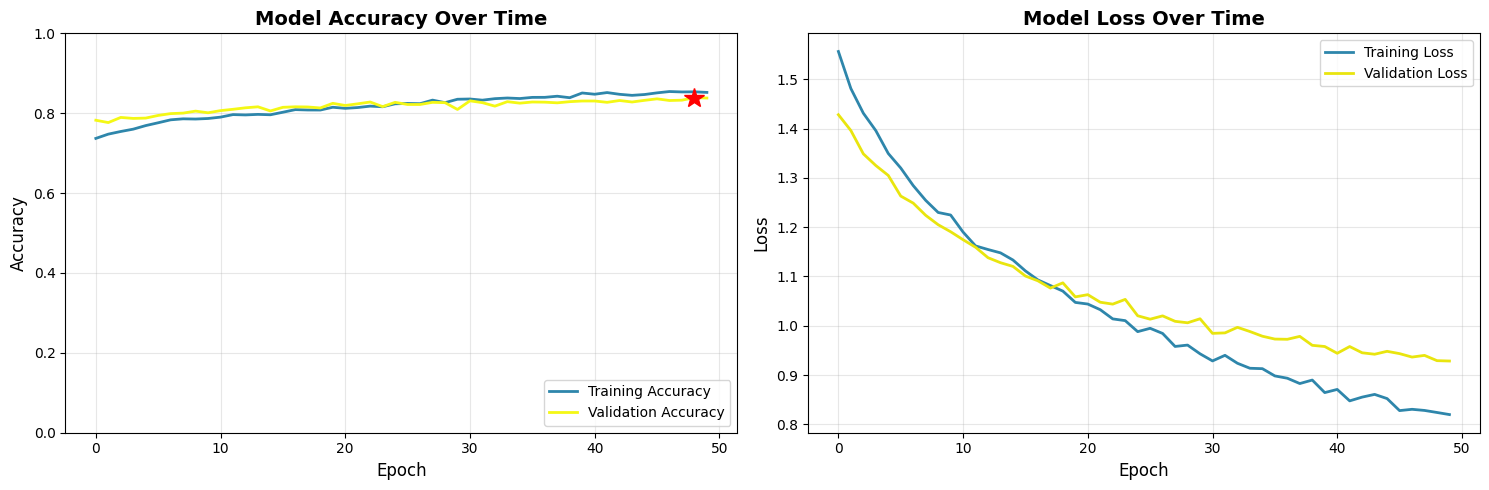


📊 PER-CLASS PERFORMANCE ON TEST SET

              precision    recall  f1-score   support

       angry     0.8963    0.8272    0.8604       324
     disgust     0.8227    0.7477    0.7834       329
        fear     0.8615    0.8511    0.8563       329
       happy     0.8202    0.7927    0.8062       328
     neutral     0.8551    0.9282    0.8901       515
         sad     0.8012    0.8110    0.8061       328
    surprise     0.8014    0.8706    0.8346       255

    accuracy                         0.8389      2408
   macro avg     0.8369    0.8326    0.8339      2408
weighted avg     0.8393    0.8389    0.8382      2408


📊 Generating confusion matrix...
✅ Confusion matrix saved as 'confusion_matrix.png'


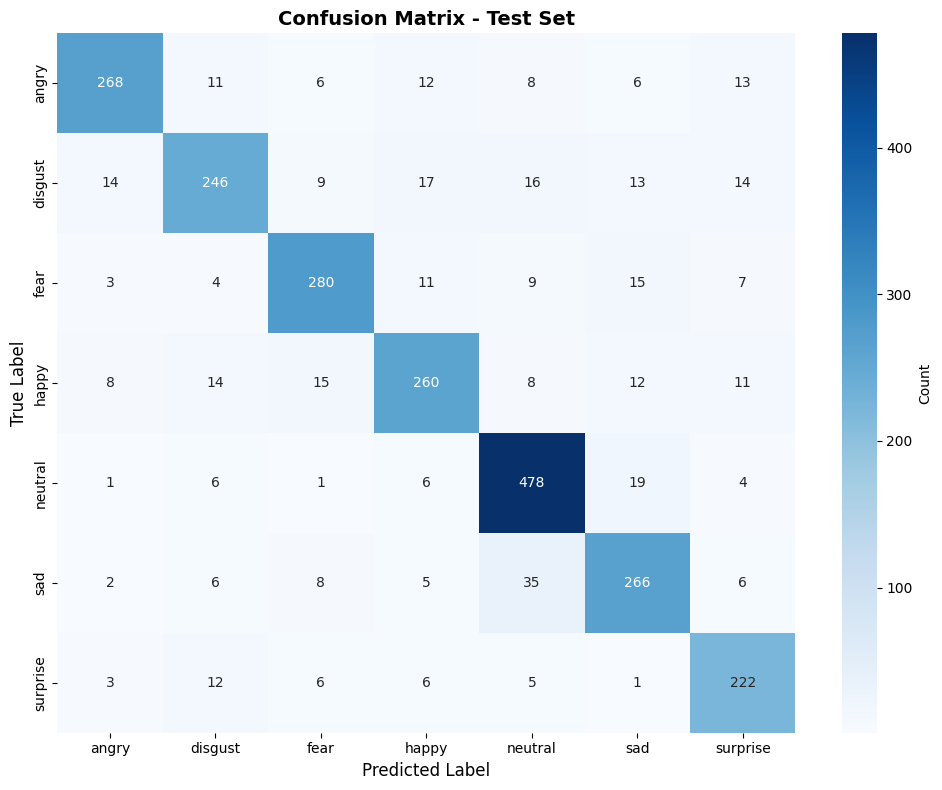


📊 Generating per-class accuracy chart...
✅ Per-class accuracy chart saved as 'per_class_accuracy.png'


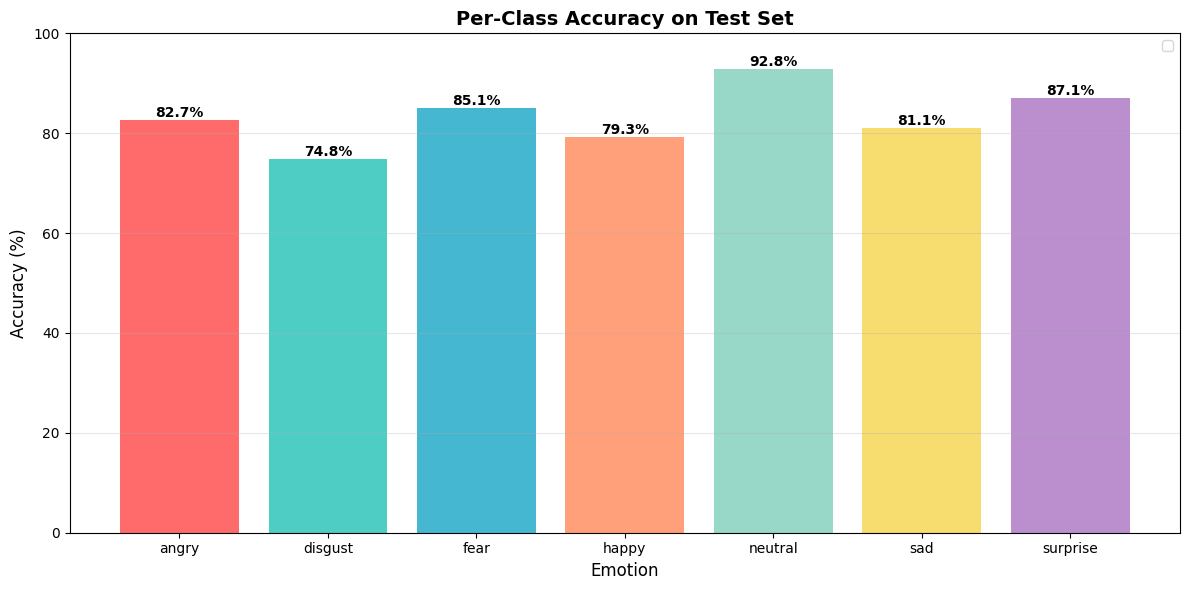


✅ ANALYSIS COMPLETE!

Generated Files:
   📊 training_curves.png
   📊 confusion_matrix.png
   📊 per_class_accuracy.png

All metrics have been displayed above! ⬆️


In [ ]:


import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model



# ========================================
# LOAD TRAINING HISTORY
# ========================================
print("\n📂 Loading training history...")

try:
    with open('training_history_advanced.pkl', 'rb') as f:
        history = pickle.load(f)
    print("✅ Loaded advanced training history")
except:
    print("⚠️ Could not find advanced history, trying other files...")
    try:
        with open('training_history_combined.pkl', 'rb') as f:
            history = pickle.load(f)
        print("✅ Loaded combined training history")
    except:
        print("❌ No history file found")
        history = None

# ========================================
# DISPLAY EPOCH-BY-EPOCH RESULTS
# ========================================
if history:
    print("\n" + "="*80)
    print("📈 EPOCH-BY-EPOCH TRAINING PROGRESS")
    print("="*80)
    
    num_epochs = len(history['accuracy'])
    
    print(f"\n{'Epoch':<8} {'Train Acc':<12} {'Val Acc':<12} {'Train Loss':<12} {'Val Loss':<12}")
    print("-" * 80)
    
    for epoch in range(num_epochs):
        train_acc = history['accuracy'][epoch] * 100
        val_acc = history['val_accuracy'][epoch] * 100
        train_loss = history['loss'][epoch]
        val_loss = history['val_loss'][epoch]
        
        # Highlight best validation accuracy
        if val_acc == max(history['val_accuracy']) * 100:
            marker = " ⭐ BEST"
        else:
            marker = ""
        
        print(f"{epoch+1:<8} {train_acc:<12.2f} {val_acc:<12.2f} {train_loss:<12.4f} {val_loss:<12.4f}{marker}")
    
    # ========================================
    # SUMMARY STATISTICS
    # ========================================
    print("\n" + "="*80)
    print("📊 TRAINING SUMMARY STATISTICS")
    print("="*80)
    
    best_epoch = np.argmax(history['val_accuracy']) + 1
    best_val_acc = max(history['val_accuracy']) * 100
    final_train_acc = history['accuracy'][-1] * 100
    final_val_acc = history['val_accuracy'][-1] * 100
    
    print(f"\n🏆 BEST PERFORMANCE:")
    print(f"   Best Epoch:           {best_epoch}")
    print(f"   Best Val Accuracy:    {best_val_acc:.2f}%")
    print(f"   Train Acc at Best:    {history['accuracy'][best_epoch-1]*100:.2f}%")
    
    print(f"\n📍 FINAL EPOCH ({num_epochs}):")
    print(f"   Final Train Accuracy: {final_train_acc:.2f}%")
    print(f"   Final Val Accuracy:   {final_val_acc:.2f}%")
    
    print(f"\n📈 IMPROVEMENT:")
    print(f"   Initial Train Acc:    {history['accuracy'][0]*100:.2f}%")
    print(f"   Initial Val Acc:      {history['val_accuracy'][0]*100:.2f}%")
    print(f"   Final Train Acc:      {final_train_acc:.2f}%")
    print(f"   Final Val Acc:        {final_val_acc:.2f}%")
    print(f"   Improvement:          +{final_val_acc - history['val_accuracy'][0]*100:.2f}%")

# ========================================
# LOAD MODEL AND EVALUATE ON TEST SET
# ========================================
print("\n" + "="*80)
print("🧪 EVALUATING ON TEST SET")
print("="*80)

try:
    print("\n📂 Loading best improved model...")
    model = load_model('CNN_model_IMPROVED_FINAL.h5')
    print("✅ Model loaded successfully")
    
    print("\n🧮 Computing test set accuracy...")
    test_loss, test_accuracy = model.evaluate(X_test_cnn, Y_test, verbose=0)
    
    print("\n" + "="*80)
    print("🎯 FINAL ACCURACY COMPARISON")
    print("="*80)
    
    if history:
        print(f"\n📊 Training Set:      {final_train_acc:.2f}%")
        print(f"📊 Validation Set:    {final_val_acc:.2f}%")
    print(f"📊 Test Set:          {test_accuracy*100:.2f}%")
    
    # Check for overfitting/underfitting
    print("\n" + "="*80)
    print("🔍 MODEL DIAGNOSIS")
    print("="*80)
    
    if history:
        train_val_gap = final_train_acc - final_val_acc
        val_test_gap = final_val_acc - test_accuracy*100
        
        print(f"\nTrain-Val Gap:  {train_val_gap:.2f}%")
        print(f"Val-Test Gap:   {val_test_gap:.2f}%")
        
        if train_val_gap > 5:
            print("\n⚠️  OVERFITTING DETECTED")
            print("   → Training accuracy much higher than validation")
            print("   → Model memorizing training data")
        elif abs(train_val_gap) < 3:
            print("\n✅ GOOD GENERALIZATION")
            print("   → Similar train and validation accuracy")
            print("   → Model learning well")
        
        if test_accuracy*100 >= 90:
            print("\n🎉 EXCELLENT! 90%+ Test Accuracy Achieved!")
        elif test_accuracy*100 >= 85:
            print("\n✅ GOOD! Strong test performance")
        elif test_accuracy*100 >= 80:
            print("\n📊 ACCEPTABLE. Room for improvement")
        else:
            print("\n⚠️  NEEDS IMPROVEMENT")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")

# ========================================
# VISUALIZE TRAINING CURVES
# ========================================
if history:
    print("\n" + "="*80)
    print("📈 GENERATING TRAINING CURVES")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Accuracy
    axes[0].plot(history['accuracy'], label='Training Accuracy', linewidth=2, color='#2E86AB')
    axes[0].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2, color="#F4F815")
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Highlight best epoch
    best_epoch_idx = np.argmax(history['val_accuracy'])
    axes[0].plot(best_epoch_idx, history['val_accuracy'][best_epoch_idx], 
                 'r*', markersize=15, label=f'Best (Epoch {best_epoch_idx+1})')
    
    # Plot Loss
    axes[1].plot(history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
    axes[1].plot(history['val_loss'], label='Validation Loss', linewidth=2, color="#E9E50E")
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    print("\n✅ Training curves saved as 'training_curves.png'")
    plt.show()

if 'model' in locals():
    print("\n" + "="*80)
    print("📊 PER-CLASS PERFORMANCE ON TEST SET")
    print("="*80)
    
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    
    # Get predictions
    y_pred = model.predict(X_test_cnn, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(Y_test, axis=1)
    
    # Convert to labels
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_test_labels = label_encoder.inverse_transform(y_test_classes)
    
    # Classification report
    print("\n" + classification_report(y_test_labels, y_pred_labels, 
                                       target_names=label_encoder.classes_,
                                       digits=4))
    
    # Confusion Matrix
    print("\n📊 Generating confusion matrix...")
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("✅ Confusion matrix saved as 'confusion_matrix.png'")
    plt.show()
    
    # Per-class accuracy bars
    print("\n📊 Generating per-class accuracy chart...")
    class_accuracies = []
    for emotion in label_encoder.classes_:
        mask = y_test_labels == emotion
        if np.sum(mask) > 0:
            acc = np.sum(y_pred_labels[mask] == y_test_labels[mask]) / np.sum(mask)
            class_accuracies.append(acc * 100)
        else:
            class_accuracies.append(0)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(label_encoder.classes_, class_accuracies, 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', 
                         '#98D8C8', '#F7DC6F', '#BB8FCE'])
    
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Per-Class Accuracy on Test Set', fontsize=14, fontweight='bold')
    plt.ylim([0, 100])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
    print("✅ Per-class accuracy chart saved as 'per_class_accuracy.png'")
    plt.show()



In [ ]:


print("\n" + "="*80)
print("🎯 PREDICTION EXAMPLES")
print("="*80)

# Select 10 random samples from test set
random_indices = np.random.choice(len(X_test_cnn), size=10, replace=False)

print("\n📋 Showing 10 random predictions:\n")

correct_predictions = 0

for idx in random_indices:
    # Get prediction
    pred_proba = model.predict(X_test_cnn[idx:idx+1], verbose=0)[0]
    pred_class = np.argmax(pred_proba)
    pred_emotion = label_encoder.inverse_transform([pred_class])[0]
    pred_confidence = pred_proba[pred_class]
    
    # Get true label
    true_class = np.argmax(Y_test[idx])
    true_emotion = label_encoder.inverse_transform([true_class])[0]
    
    # Check if correct
    is_correct = pred_emotion == true_emotion
    if is_correct:
        correct_predictions += 1
    
    # Display
    status = "✅ CORRECT" if is_correct else "❌ INCORRECT"
    print(f"{status}")
    print(f"   True Emotion: {true_emotion.upper()}")
    print(f"   Predicted: {pred_emotion.upper()} (Confidence: {pred_confidence*100:.2f}%)")
    print("-" * 80)

accuracy_sample = (correct_predictions / 10) * 100
print(f"\n📊 Sample Accuracy: {correct_predictions}/10 ({accuracy_sample:.0f}%)")
print("="*80)


🎯 PREDICTION EXAMPLES

📋 Showing 10 random predictions:

✅ CORRECT
   True Emotion: NEUTRAL
   Predicted: NEUTRAL (Confidence: 98.46%)
--------------------------------------------------------------------------------
✅ CORRECT
   True Emotion: DISGUST
   Predicted: DISGUST (Confidence: 99.07%)
--------------------------------------------------------------------------------
✅ CORRECT
   True Emotion: SAD
   Predicted: SAD (Confidence: 89.65%)
--------------------------------------------------------------------------------
❌ INCORRECT
   True Emotion: DISGUST
   Predicted: SAD (Confidence: 24.72%)
--------------------------------------------------------------------------------
✅ CORRECT
   True Emotion: NEUTRAL
   Predicted: NEUTRAL (Confidence: 99.87%)
--------------------------------------------------------------------------------
✅ CORRECT
   True Emotion: ANGRY
   Predicted: ANGRY (Confidence: 98.31%)
--------------------------------------------------------------------------------
✅ 

In [ ]:


def predict_emotion(audio_path, show_all_probabilities=False):
    """
    Predict emotion from audio file
    
    Args:
        audio_path: Path to audio file
        show_all_probabilities: If True, show probabilities for all emotions
    
    Returns:
        Tuple of (emotion, confidence)
    """
    try:
        # Extract features
        features = get_features_no_augmentation(audio_path)
        
        if features is None:
            print("❌ Error extracting features")
            return None, None
        
        # Scale features
        features_scaled = scaler.transform(features.reshape(1, -1))
        
        # Reshape for CNN
        features_cnn = np.expand_dims(features_scaled, axis=2)
        
        # Predict
        predictions = model.predict(features_cnn, verbose=0)[0]
        
        # Get emotion
        emotion_idx = np.argmax(predictions)
        emotion = label_encoder.inverse_transform([emotion_idx])[0]
        confidence = predictions[emotion_idx]
        
        # Display results
        print("\n" + "="*80)
        print(f"🎵 Audio File: {os.path.basename(audio_path)}")
        print("="*80)
        print(f"🎯 Predicted Emotion: {emotion.upper()}")
        print(f"📊 Confidence: {confidence*100:.2f}%")
        
        if show_all_probabilities:
            print(f"\n📊 All Emotion Probabilities:")
            print("━"*80)
            sorted_indices = np.argsort(predictions)[::-1]
            for idx in sorted_indices:
                emo = label_encoder.inverse_transform([idx])[0]
                prob = predictions[idx]
                bar = "█" * int(prob * 50)
                print(f"   {emo.capitalize():15s}: {prob*100:6.2f}% {bar}")
        
        print("="*80 + "\n")
        
        return emotion, confidence
    
    except Exception as e:
        print(f"❌ Error: {e}")
        return None, None

print("✅ Prediction function defined!")
print("\nUsage:")
print("   predict_emotion('path/to/audio.wav')")
print("   predict_emotion('path/to/audio.wav', show_all_probabilities=True)")

✅ Prediction function defined!

Usage:
   predict_emotion('path/to/audio.wav')
   predict_emotion('path/to/audio.wav', show_all_probabilities=True)


In [ ]:


from IPython.display import Audio, display
import ipywidgets as widgets
import numpy as np
import os
import glob

# Paths to your custom datasets
custom_dataset1 = r"F:\8th Sem project All collectoin\Datasets\Custom_Datasets"
custom_dataset2 = r"F:\8th Sem project All collectoin\Datasets\Custom_Datasets2"

# Get all audio files
audio_files = glob.glob(os.path.join(custom_dataset1, "*.wav")) + \
              glob.glob(os.path.join(custom_dataset2, "*.wav"))



# Pick 5 random files
sample_files = np.random.choice(audio_files, size=5, replace=False)



for i, audio_path in enumerate(sample_files, 1):
    # Assuming your true labels are in the filename, e.g., happy_01.wav
    true_emotion = os.path.basename(audio_path).split('_')[0]
    
    predicted_emotion, confidence = predict_emotion(audio_path, show_all_probabilities=False)
    
 
    
    # Inline play button
    display(Audio(audio_path, autoplay=False))
    
    print("="*80)





🎵 Audio File: Sugam Shakya_Neutral_20260125_054813.wav
🎯 Predicted Emotion: NEUTRAL
📊 Confidence: 99.99%




🎵 Audio File: Yogesh Bishwokarma_Angry_20260127_151200.wav
🎯 Predicted Emotion: ANGRY
📊 Confidence: 99.95%




🎵 Audio File: Bikram Luhar _Happy_20260127_144231.wav
🎯 Predicted Emotion: HAPPY
📊 Confidence: 99.96%




🎵 Audio File: Sugam Shakya_Neutral_20260125_054950.wav
🎯 Predicted Emotion: NEUTRAL
📊 Confidence: 99.97%




🎵 Audio File: Karuna Dahal_Surprise_20260125_145620.wav
🎯 Predicted Emotion: SURPRISE
📊 Confidence: 100.00%



In [76]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# =============================================================================
# OPTION 1: SIMPLE PITCH-BASED GENDER DETECTION
# =============================================================================

def detect_gender_simple(audio_path):
    y, sr = librosa.load(audio_path, duration=2.5, offset=0.6)

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]

    if len(pitch_values) == 0:
        return "Unknown"

    mean_pitch = np.mean(pitch_values)
    return "Male" if mean_pitch < 165 else "Female"


# =============================================================================
# RAVDESS GENDER EXTRACTION
# =============================================================================

def extract_gender_from_ravdess_filename(filename):
    try:
        parts = filename.split('-')
        actor_id = int(parts[6].split('.')[0])
        return "Male" if actor_id % 2 == 1 else "Female"
    except:
        return "Unknown"


# =============================================================================
# DATASET PREPARATION
# =============================================================================

def prepare_gender_dataset(data_path, emotion_df=None):
    gender_data = []

    if emotion_df is not None:
        for _, row in emotion_df.iterrows():
            filename = os.path.basename(row['path'])
            gender = extract_gender_from_ravdess_filename(filename)

            if gender != "Unknown":
                gender_data.append({
                    'path': row['path'],
                    'gender': gender,
                    'features': row.get('features', None)
                })

    return pd.DataFrame(gender_data)


# =============================================================================
# FEATURE EXTRACTION
# =============================================================================

def extract_gender_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, duration=2.5, offset=0.6)

        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch_values = pitches[magnitudes > np.median(magnitudes)]

        if len(pitch_values) > 0:
            pitch_mean = np.mean(pitch_values)
            pitch_std = np.std(pitch_values)
            pitch_min = np.min(pitch_values)
            pitch_max = np.max(pitch_values)
        else:
            pitch_mean = pitch_std = pitch_min = pitch_max = 0

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        return np.hstack([
            pitch_mean, pitch_std, pitch_min, pitch_max,
            spectral_centroid, spectral_rolloff,
            mfcc_mean
        ])

    except:
        return None


# =============================================================================
# MODEL
# =============================================================================

def build_gender_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model
